# Projet 6: Classifiez automatiquement des biens de consommation

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
# for preprocessing
import re
import string
# Réduction de dimensions
from sklearn.manifold import TSNE
#topic modelling
from sklearn.decomposition import LatentDirichletAllocation
# Traitement des données textuelles
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score
from keras.models import Sequential, Model, model_from_json
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image

**Description et nettoyage du data set**

In [ ]:
downloaded = drive.CreateFile({'id':'1yjSi_5KUG8X3x_YIkWnR5s038LG35sxb'})
downloaded.GetContentFile('flipkart_com-ecommerce_sample_1050.csv')
# Lecture du données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [ ]:
df.shape

(1050, 15)

 Valeurs manquantes

In [ ]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

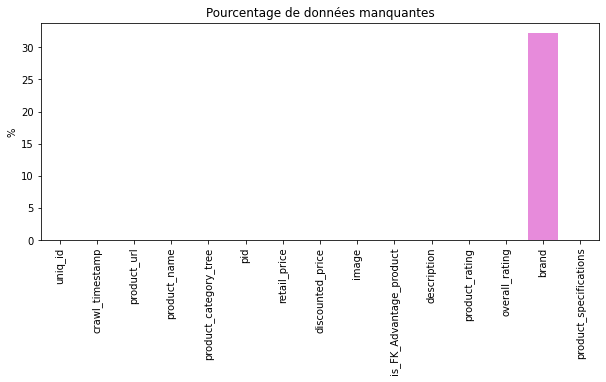

In [ ]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()

Travail sur les variables description et catégorie du produit

In [ ]:
## La catégorie du premier produit
df['product_category_tree'].iloc[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

Chaque produit est catégorisé par un système d'arbres avec plusieurs profondeurs

In [ ]:
df['product_category_tree']= df['product_category_tree'].str[2:-2]

In [ ]:
df['product_category_1']= df['product_category_tree'].str.split('>>',expand=True)[0]

In [ ]:
df['product_category_1'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [ ]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_1
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing >> Curtains & Accessories >> C...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing >> Bed Linen >> Bedsheets >> S...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing >> Bed Linen >> Bedsheets >> J...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


In [ ]:
#le = LabelEncoder()
#df['Class'] = le.fit_transform(df['product_category_1'])

In [ ]:
print('il y a {} catégories uniques'.format(df['product_category_1'].nunique()))

il y a 7 catégories uniques


Répartition des catégories dans la profondeur 1 des produits

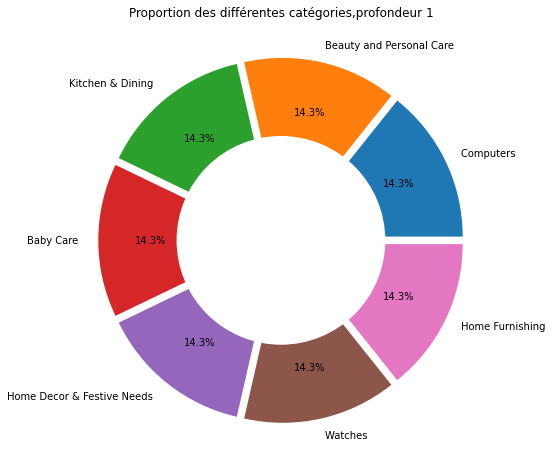

In [ ]:
#% de produits par categories
plt.figure(figsize=[12,8])
plt.title("Proportion des différentes catégories,profondeur 1")
plt.pie(df['product_category_1'].value_counts().values,labels=df['product_category_1'].value_counts().index,autopct='%1.1f%%',pctdistance=0.7, explode = [0.05]*df['product_category_1'].value_counts().values.shape[0])
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


Il y a 150 image par catégorie de première profondeur

Analyse des descriptions des produits

In [ ]:
df['product_name'].iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

In [ ]:
df['brand'].iloc[0]

'Elegance'

In [ ]:
df["description"].iloc[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [ ]:
#df['description'] = df["product_name"] + df["brand"] + df["description"]

la description du produit contient le nom du produit, la marque ainsi que la description du produit.

In [ ]:
df["description"].iloc[6]

'Camerii WM64 Elegance Analog Watch  - For Men, Boys - Buy Camerii WM64 Elegance Analog Watch  - For Men, Boys  WM64 Online at Rs.449 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


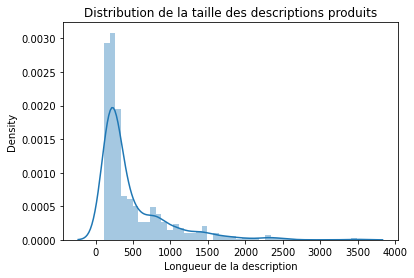

In [ ]:
description_length = []
for i in df['description']:
  description_length.append(len(i))
plt.xlabel('Longueur de la description')
plt.title('Distribution de la taille des descriptions produits')
sns.distplot(description_length)

**Nettoyage de texte**


Avant de commencer l'extraction des mots, nous allons nettoyer le texte par le preprocessing suivante :

**Preprocessing**

- retrait de la ponctuation
- mise en minuscule
- retrait les nombres
- tokenization du texte
- retrait des stopwords
- lemmatisation du corpus

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Exemple d'un description à traiter

In [ ]:
from nltk import word_tokenize
def affiche_liste(liste):
    return liste

description_example = df['description'].iloc[11]
print('PREPROCESSING')
print(affiche_liste(description_example),'\n')
#lowercase
description_example = description_example.lower()
print('LOWERCASE')
print(affiche_liste(description_example),'\n')

#remove number
description_example = ''.join(c for c in description_example if not c.isdigit())
print('REMOVE NUMBER')
print(affiche_liste(description_example),'\n')

#tokenizer
tokenizer = RegexpTokenizer(r'\w+')
description_example = tokenizer.tokenize(description_example)
print('TOKENIZER')
print(affiche_liste(description_example),'\n')

#stopwords
description_example = [w for w in description_example if not w in stopwords_nltk ]
print('STOPWORDS')
print(affiche_liste(description_example),'\n')

#lemmatizer
lemm = WordNetLemmatizer()
description_example = [lemm.lemmatize(el) for el in description_example]
print('LEMMATISATION')
print(affiche_liste(description_example),'\n')


PREPROCESSING
Cartier W6701005 Analog Watch  - For Boys, Men - Buy Cartier W6701005 Analog Watch  - For Boys, Men  W6701005 Online at Rs.201000 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery! 

LOWERCASE
cartier w6701005 analog watch  - for boys, men - buy cartier w6701005 analog watch  - for boys, men  w6701005 online at rs.201000 in india only at flipkart.com. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery! 

REMOVE NUMBER
cartier w analog watch  - for boys, men - buy cartier w analog watch  - for boys, men  w online at rs. in india only at flipkart.com. - great discounts, only genuine products,  day replacement guarantee, free shipping. cash on delivery! 

TOKENIZER
['cartier', 'w', 'analog', 'watch', 'for', 'boys', 'men', 'buy', 'cartier', 'w', 'analog', 'watch', 'for', 'boys', 'men', 'w', 'online', 'at', 'rs', 'in', 'india', 'only', 'at',

NLTK possède une liste de mots vides pour l'anglais

In [ ]:
stopwords_nltk

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

 most_common words of our corpus

In [ ]:
from collections import Counter
#On recrée une chaîne "propre"
c= Counter(" ".join(df["description"]).split())
c.most_common(40)

[('of', 1656),
 ('and', 1167),
 ('the', 1013),
 ('to', 982),
 ('-', 910),
 ('for', 819),
 ('in', 748),
 ('Only', 717),
 ('at', 701),
 ('with', 688),
 ('your', 600),
 ('Rs.', 584),
 ('For', 584),
 ('Buy', 566),
 ('Genuine', 564),
 ('a', 555),
 ('is', 544),
 ('Replacement', 518),
 ('&', 492),
 ('30', 486),
 ('cm', 473),
 ('Day', 473),
 ('On', 425),
 ('Products.', 413),
 ('Free', 403),
 ('on', 402),
 ('Shipping.', 381),
 ('Cash', 381),
 ('Delivery!', 381),
 ('Flipkart.com.', 379),
 ('1', 365),
 ('from', 352),
 ('Price:', 342),
 ('The', 338),
 ('Features', 327),
 ('Guarantee.', 318),
 ('Watch', 292),
 ('In', 287),
 ('Baby', 287),
 ('General', 285)]

Text(0.5, 1.0, 'Mots les plus communs dans la description')

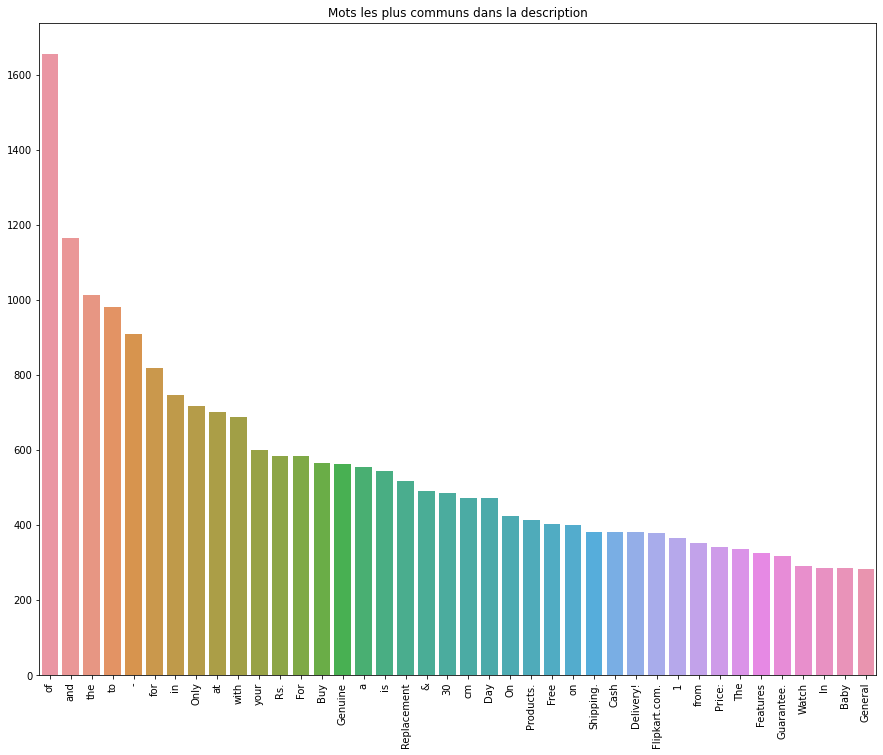

In [ ]:
words = [word[0] for word in c.most_common(40)]
counts = [word[1] for word in c.most_common(40)]
plt.figure(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=words, y=counts)
plt.title("Mots les plus communs dans la description")

Ce graphe représenter les mots les plus fréquemment utilisés dans la description des produits.

Fonction de preprocessing des données textuelles

In [ ]:
# make all text lowercase
def lowercase(text):#.str.lower()
    return text.lower()

# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_numbers(text):
  text= re.sub(r'\d+', '', text)
  return text

# tokenizer
#Create a tokenizer base on regular expression '\w+' which will take any group of [0-9] and [a-z] character
def tokenizer(text):
  tokenizer = RegexpTokenizer(r'\w+')
  text = tokenizer.tokenize(text)
  return text

# remove stopwords
#add some common words in our own problematic (words like "product, prize, delivery, ...")
def remove_stopwords(text):
  text = [word for word in text if not word  in stopwords_nltk]
  return text

# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  text = [lemmatizer.lemmatize(words) for words in text]
  return text

def preprocessing(text):
    text = lowercase(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenizer(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = ' '.join(text)
    return text

In [ ]:
df['newdescription'] = df['description'].apply(preprocessing)

In [ ]:
df['newdescription']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker r ...
1049    buy uberlyfe large vinyl sticker r online uber...
Name: newdescription, Length: 1050, dtype: object

In [ ]:
df=df[['newdescription','image','product_category_1']]

**Représentations des descriptions**
- on représenter les mots les plus fréquemment utilisés dans la totalité des descriptions de notre jeu de données. Sous la forme d'un nuage de mots.



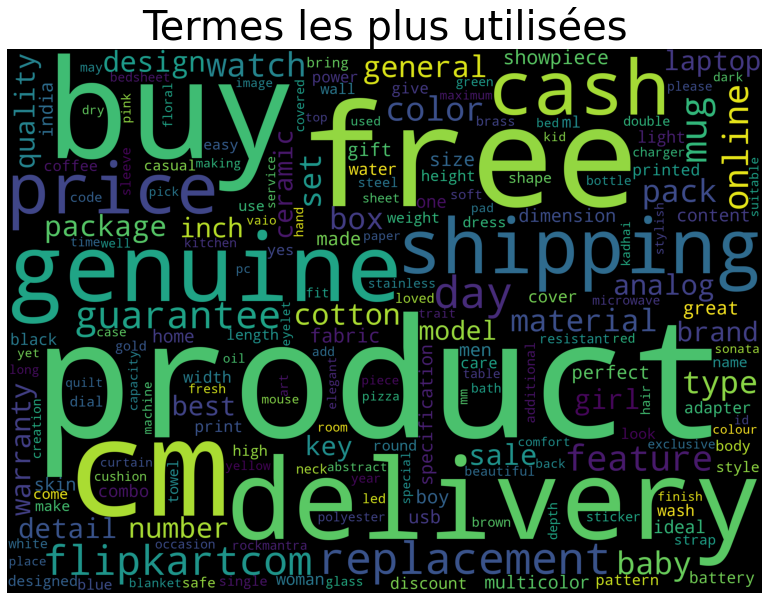

In [ ]:
#Visualisation des mots les plus utilisés dans les descriptions
plt.figure(figsize=(20, 10))
text = df.newdescription.values

cloud = WordCloud(
    background_color='black',
    collocations=False,
    width=2500,
    height=1800
).generate(" ".join(text))

plt.axis('off')
plt.title("Termes les plus utilisées", fontsize=40)
plt.imshow(cloud)

Création de datasets d'apprentissages

- train : descriptions

- target : catégories de produit

In [ ]:
train,test = train_test_split(df,test_size=0.20,stratify=df.product_category_1)

**Méthode BOW**

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Assemblage des pipelines pré-traitement des données et la classification

In [ ]:
#Grille d'hyperparamètres pour le BoW et gradient boosting
param={'countvectorizer__max_df':[0.8,0.9,1],  # ignore terms that appear in more than max_df*100% of the documents
'countvectorizer__min_df':[1, 3, 5],
"countvectorizer__max_features": [200,300,400,500,600],# Dimension du BoW testé.
"xgbclassifier__learning_rate":[10,1,0.1,0.01],
'xgbclassifier__n_estimators':[10,100,200,300]
}

In [ ]:
# Vectorisation
#fonction CountVectorizer: permet d'extraire les mots d'un texte.
tfvectorizer = CountVectorizer(strip_accents='unicode',lowercase=True,analyzer='word',stop_words=stopwords.words('english'))
#Transforme les données afin d'effectue une classification
model_pipeline1 = make_pipeline(tfvectorizer,XGBClassifier(random_state=0))# Pipeline Tf-idf + xgb

In [ ]:
%%time
rnd = GridSearchCV(model_pipeline1,param_grid=param)
# Entrainement du modèle
search= rnd.fit(train['newdescription'],train['product_category_1'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. T

CPU times: user 37min 39s, sys: 11.8 s, total: 37min 50s
Wall time: 37min 52s


In [ ]:
print("Les meilleurs paramètres du Countervectorizer et XGBoosting sont : {}".format(search.best_params_))

Les meilleurs paramètres du Countervectorizer et XGBoosting sont : {'countvectorizer__max_df': 0.8, 'countvectorizer__max_features': 500, 'countvectorizer__min_df': 1, 'xgbclassifier__learning_rate': 1, 'xgbclassifier__n_estimators': 200}


In [ ]:
tf_counterV =search.best_estimator_[0]

In [ ]:
df_bow = pd.DataFrame(tf_counterV.transform(train['newdescription']).toarray(), columns=tf_counterV.get_feature_names())#terme de frequence

Dataframe sous forme de Bag of Words

In [ ]:
df_bow

,abstract,ac,accessory,actual,adapter,add,additional,adorable,affordable,air,also,aluminium,analog,android,antique,apple,apply,area,aroma,around,art,assured,attractive,available,baby,back,backpack,bag,bath,battery,beautiful,beautifully,beauty,bed,bedroom,bedsheet,best,black,blanket,bleach,...,usb,use,used,using,va,vacuum,vaio,vanity,vary,velvet,vinyl,voltage,wall,wallmantra,wardrobe,warm,warranty,wash,washable,watch,water,waterproof,way,wear,weight,well,white,wide,width,without,woman,wood,wooden,work,wrap,year,yellow,yes,yet,youre
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0
836,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
837,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
838,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0


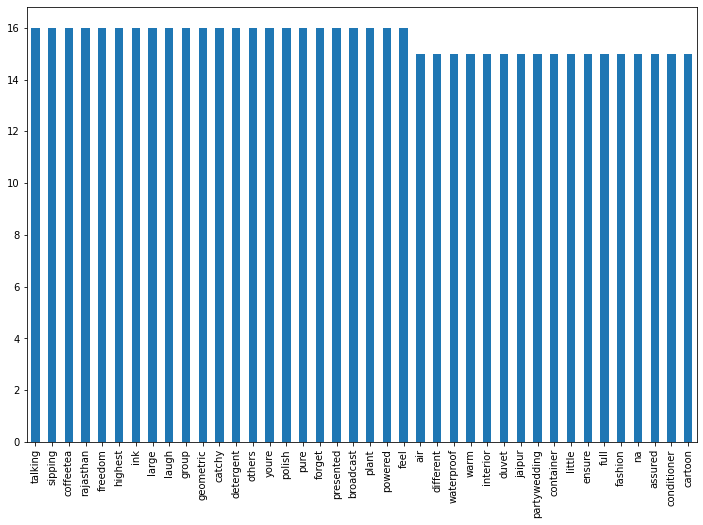

In [ ]:
plt.figure(figsize=(12,8))
df_bow.sum(axis=0).sort_values(ascending=False)[-40:].plot.bar()
plt.title('')
plt.show()

Termes les moins fréquents dans l'ensemble des descriptions

In [ ]:
xgb1= search.best_estimator_[1]

In [ ]:
print('accuracy sur jeu test : ', accuracy_score(xgb1.predict(tf_counterV.transform(test['newdescription'])), test['product_category_1']))

accuracy sur jeu test :  0.8952380952380953


                         Matrice de confusion


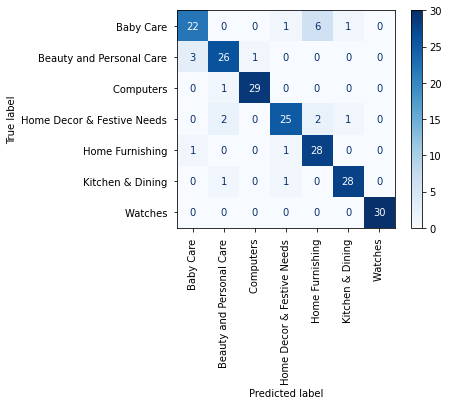

In [ ]:
print('                         Matrice de confusion')
plot_confusion_matrix(xgb1,tf_counterV.transform(test['newdescription']),
                      test['product_category_1'],
                      xticks_rotation=90,
                      cmap='Blues')

plt.show()

 **Méthode BOW-LDA**

In [ ]:
# Modèle LDA
lda= LatentDirichletAllocation(n_components=train['product_category_1'].nunique())

In [ ]:
lda.fit(tf_counterV.transform(train['newdescription']))

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
display_topics(lda,tf_counterV.get_feature_names(), 10)


Topic 0:
mug ceramic gift home one coffee perfect price art add

Topic 1:
cm color pack package cotton feature box sale number general

Topic 2:
mug design usb paper bring perfect eyelet coffee curtain designed

Topic 3:
baby detail girl set boy dress usb ceramic sleeve mug

Topic 4:
skin set laptop towel type light color ml feature price

Topic 5:
free delivery cash genuine shipping buy product day guarantee replacement

Topic 6:
product warranty laptop adapter battery quality power replacement charger please


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


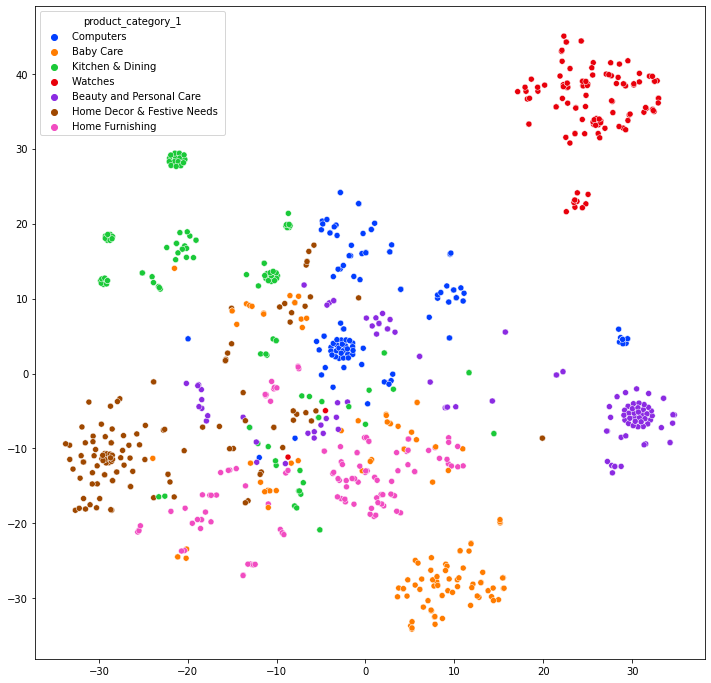

In [ ]:
tsne_bow = TSNE()
X_tsne= tsne.fit_transform(tf_counterV.transform(train['newdescription']))
fig = plt.figure(figsize=(12, 12))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne[:,0], X_tsne[:, 1],hue=train['product_category_1'], legend='full', palette=pal)#hue=kmeans_model2.labels_

**Méthode TF-IDF**

cette méthode consiste à donner un poids élevé aux termes qui apparaissent souvent dans un document particulier, mais pas dans de nombreux documents du corpus. Si un mot apparaît souvent dans un certain document, donc s'il y a une fréquence élevée, mais très rarement ailleurs, il est probablement très représentatif du contenu de CE document.

In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode',lowercase=True,analyzer='word',stop_words=stopwords.words('english'))
#Transforme les données afin d'effectue une classification
model_pipeline2 = make_pipeline(vectorizer,XGBClassifier(random_state=0))# Pipeline Tf-idf + xgb

In [ ]:
#Grille d'hyperparamètres pour le Tf-idf et gradient boosting
param={'tfidfvectorizer__max_df':[0.1, 0.5, 0.8,1],  # ignore terms that appear in more than max_df*100% of the documents
    'tfidfvectorizer__min_df':[1, 3, 5,7],  # only keep terms that appear in at least min_df documents
"tfidfvectorizer__max_features": [300,400,500,600],
"xgbclassifier__learning_rate":[1,0.1,0.01],
'xgbclassifier__n_estimators':[50,100,200,300]
}

In [ ]:
%%time
rnd2 = GridSearchCV(model_pipeline2,param_grid=param)
# Entrainement du modèle
search2= rnd2.fit(train['newdescription'],train['product_category_1'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_df corresponds to < documents than min_df

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. T

CPU times: user 1h 21min 14s, sys: 17 s, total: 1h 21min 31s
Wall time: 1h 21min 23s


In [ ]:
print("Les meilleurs paramètres sont : {}".format(search2.best_params_))

Les meilleurs paramètres sont : {'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__max_features': 500, 'tfidfvectorizer__min_df': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200}


In [ ]:
tf_idf1 =search2.best_estimator_[0]

In [ ]:
tfidf_vect = tf_idf1.transform(train['newdescription']).toarray().astype("float32")

In [ ]:
train["tf_idf"] =  ""

for i in range(train.shape[0]):
    train["tf_idf"][i] = tfidf_vect[i]

train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,newdescription,image,product_category_1,tf_idf
765,nutcase sticker wrap design teal pink watercol...,3d8222014ec36292c1c143c5f5e12c29.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
360,flipkartcom buy nike casual combo set online r...,cc9412969fab14faba65c70e00fef4a8.jpg,Beauty and Personal Care,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,specification rythmx fb nail polish black lips...,5e84d36ad6db970548498829db8b15de.jpg,Beauty and Personal Care,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
296,specification ball ibctdc gbddr dual core ram ...,458c697fe5824552890b0e674cf5c109.jpg,Computers,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
648,specification esteem baby boy drawer general d...,9656b0a52d364da5eed38a4bb2d9f6e5.jpg,Baby Care,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.140031, 0.0, ..."


In [ ]:
tfidf_train = pd.DataFrame(tf_idf1.transform(train['newdescription']).toarray())

In [ ]:
df_tfidf = pd.DataFrame(tf_idf1.transform(train['newdescription']).toarray(), columns=tf_idf1.get_feature_names())

Dataframe sous forme TF-IDF

In [ ]:
df_tfidf

,abstract,ac,accessory,actual,adapter,add,additional,adhesive,adorable,affordable,age,akup,also,aluminium,analog,android,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,back,bag,bath,battery,beautiful,beautifully,beauty,bed,bedroom,bedsheet,best,black,...,unique,usb,use,used,using,va,vaio,vanity,vary,velvet,vinyl,voltage,wall,warranty,wash,washable,watch,water,waterproof,way,wear,weight,well,wheel,white,wide,width,without,woman,wood,wooden,work,would,wrap,year,yellow,yes,yet,ym,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.434908,0.000000,0.0,0.000000,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157008,...,0.0,0.0,0.150699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162660,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.147562,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.309597,0.0,0.00000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518906,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.077513,0.0,0.0,0.0,0.0,0.073564,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.192147,0.0,0.000000,0.0,0.00000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.275332,0.0,0.000000,0.127157,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.234594,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.279064,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.69508,0.0
836,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.109764,0.0,0.0,0.0,0.055958,0.0,0.0,0.0,0.0,0.053108,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.118835,0.0,0.00000,0.0
837,0.0,0.0,0.0,0.0,0.0,0.0,0.199153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00

In [ ]:
feature_names = np.array(tf_idf1.get_feature_names())
sorted_by_idf = np.argsort(tf_idf1.idf_)
print("Features avec basse valeur idf :\n",feature_names[sorted_by_idf[:100]])

Features avec basse valeur idf :
 ['day' 'replacement' 'guarantee' 'flipkartcom' 'online' 'general'
 'feature' 'box' 'type' 'color' 'sale' 'best' 'package' 'pack' 'number'
 'brand' 'key' 'material' 'cm' 'india' 'great' 'set' 'watch' 'model'
 'design' 'ideal' 'dimension' 'content' 'discount' 'specification'
 'analog' 'cotton' 'made' 'detail' 'fabric' 'showpiece' 'quality'
 'pattern' 'name' 'combo' 'girl' 'water' 'multicolor' 'baby' 'care' 'size'
 'width' 'gift' 'height' 'men' 'boy' 'home' 'ceramic' 'inch' 'weight'
 'woman' 'style' 'perfect' 'wash' 'additional' 'round' 'mug' 'use' 'strap'
 'yes' 'also' 'give' 'black' 'ml' 'printed' 'length' 'resistant' 'body'
 'one' 'dial' 'occasion' 'high' 'warranty' 'make' 'look' 'cover' 'id'
 'casual' 'come' 'designed' 'blue' 'code' 'print' 'light' 'like' 'depth'
 'laptop' 'safe' 'double' 'easy' 'usb' 'abstract' 'soft' 'sleeve' 'steel']


In [ ]:
transformation = []
for i, el  in enumerate(tf_idf1.transform(train['newdescription']).todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((tf_idf1.get_feature_names()[i], el))
pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

,mot,tfidf
0,bedsheet,0.553491
31,sheet,0.428077
15,flat,0.322415
32,single,0.306282
5,cm,0.237325
6,collection,0.211543
9,cotton,0.182212
29,printed,0.163567
28,pillow,0.152833
11,depth,0.116361


**Méthode TF-IDF et NMF**

Factorisation de matrice non négative (NMF)

In [ ]:
nmf = NMF(n_components=train.product_category_1.nunique(),random_state=1,alpha=0.1,l1_ratio=0.5,init='nndsvd')
nmf.fit(tf_idf1.transform(train['newdescription']))

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=7, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
display_topics(nmf, tf_idf1.get_feature_names(), 10)


Topic 0:
flipkartcom guarantee replacement day online cell best battery kadhai laptop

Topic 1:
watch analog men discount india great woman online dial strap

Topic 2:
baby girl detail cotton fabric dress boy neck sleeve ideal

Topic 3:
showpiece cm best online guarantee replacement day handicraft statue brass

Topic 4:
mug ceramic coffee perfect prithish rockmantra one gift loved design

Topic 5:
combo set flipkartcom online towel skin cotton soap kit polish

Topic 6:
abstract single blanket flipkartcom double quilt comforter multicolor floral dohar


In [ ]:
xgb2= search2.best_estimator_[1]

In [ ]:
xgb2.predict(tf_idf1.transform(test['newdescription']))

In [ ]:
print('accuracy sur jeu test : ', accuracy_score(xgb2.predict(tf_idf1.transform(test['newdescription'])), test['product_category_1']))

accuracy sur jeu test :  0.9142857142857143


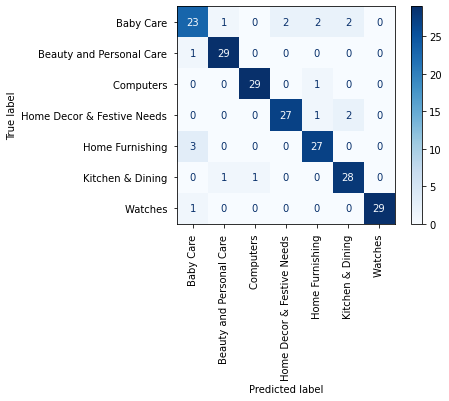

In [ ]:
plot_confusion_matrix(xgb2,tf_idf1.transform(test['newdescription']),
                      test['product_category_1'],
                      xticks_rotation=90,
                      cmap='Blues')

plt.show()

In [ ]:
tfidf_t=tf_idf1.transform(test['newdescription'])
tfidf_test = pd.DataFrame(tfidf_t.toarray())

Le tf-idf a un impact positif car notre performance passe à 91%.

 Image Data

**Preprocessing**

Le preprocessing sur les images:

- Chargement des images en niveau de gris
- Contraste en normalisant l'histogramme de chaque image
- Application d'un filtre médian
- Application d'un filtre Gaussien
- Extraction des descripteurs de l'image par l'algo ORB

**Bag Of Visual Words**

In [ ]:
#!unzip -uq "/content/drive/My Drive/Images.zip" -d "/content/drive/My Drive/Images/"

In [ ]:
import os, sys
import cv2
from skimage import io
from PIL import Image, ImageOps,ImageFilter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Open a file
path = "/content/drive/MyDrive/Images/Images/"
dirs = os.listdir( path ) #Images

In [ ]:
path1= os.path.join(path,train.iloc[1,1])

In [ ]:
img = io.imread(path1)
img_c =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_g=cv2.imread(path1, cv2.IMREAD_GRAYSCALE)

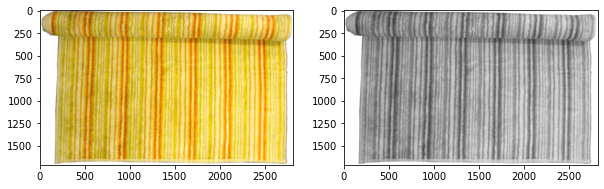

In [ ]:
fig,(ax1, ax2)= plt.subplots(1, 2,figsize=(10,10))
ax1.imshow(img_c)
ax2.imshow(img_g,cmap='gray')

In [ ]:
# Dimension de l'image (en pixel).
img_g.shape

(1712, 2814)

In [ ]:
#recadrer image
img_g = cv2.resize(img_g, (224,224), interpolation = cv2.INTER_AREA)

In [ ]:
img_g.shape

(224, 224)

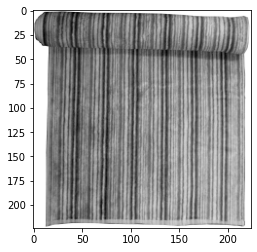

In [ ]:
plt.imshow(img_g,'gray')

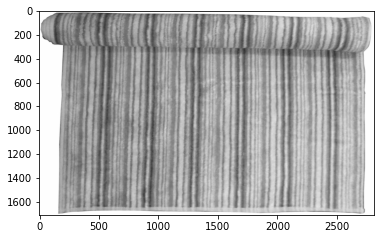

In [ ]:
#Conversion en niveau de gris de l'image
img = Image.open(path1).convert("L")
plt.imshow(img,'gray')

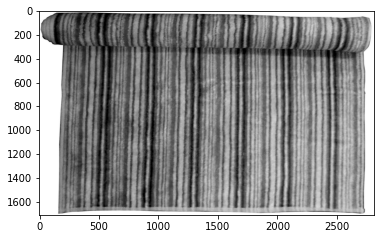

In [ ]:
img = ImageOps.autocontrast(img, cutoff=0.5)
plt.imshow(img,'gray')

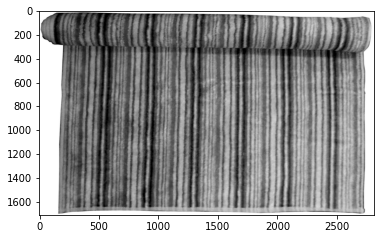

In [ ]:
im = img.filter(ImageFilter.MedianFilter(size=3))
plt.imshow(im,'gray')

égalisation de l’histogramme concerne en fait la modification de l'intensité des pixels pour améliorer le contraste de l'image.

histogramme : diagramme décrivant le nombre de pixels d'une image à chaque valeur d'intensité trouvée dans cette image

In [ ]:
hist, bins = np.histogram(img, 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()
#histplot`

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


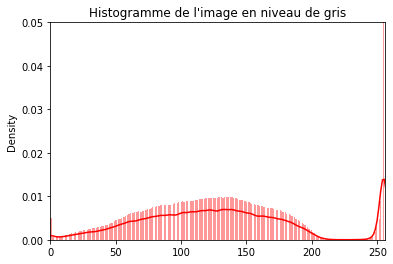

In [ ]:
plt.figure(figsize=(6,4))
plt.title("Histogramme de l'image en niveau de gris")
sns.distplot(img,256,[0,256], color = 'r')
plt.xlim([0,256])
plt.ylim([0,0.05])
plt.show()

In [ ]:
#Egalisation de l'histogramme
im = ImageOps.equalize(img)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


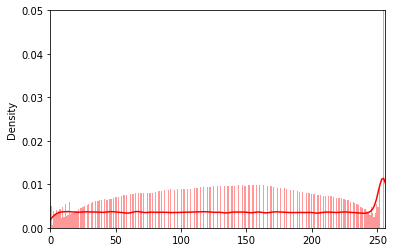

In [ ]:
hist, bins = np.histogram(im, 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure(figsize=(6,4))
sns.distplot(im,256,[0,256], color = 'r')
plt.xlim([0,256])
plt.ylim([0,0.05])
plt.show()

Fonction traitement des images

In [ ]:
def load_images(list_of_path):
    images = []
    for each_image in list_of_path:

            full_path= os.path.join(path,each_image)
            img=cv2.imread(full_path, cv2.IMREAD_GRAYSCALE) #On convertit les images en niveaux de gris
            img =cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)#Redimensionnement les images pour appliquer le CNN dans la suite : en entrée des images de 224x224
            images.append(img)


    return images

In [ ]:
%%time
train_loaded = load_images(train['image'])

CPU times: user 21.8 s, sys: 942 ms, total: 22.7 s
Wall time: 3min 55s


Extraction des features

Afin de trouver des features qui nous permettrons de comparer des images entre elles, nous allons essayer l'algorithme ORB. C'est une alternative aux algorithmes SIFT et SURF

L'extraction de features par ORB se fait en 4 étapes :

- Récupérer les descripteurs de chaque image
- Kmeans sur l'ensemble de descripteurs
- Creation de bag of visual words pour chaque iamge
- Classification de BoVW avec un classifieur

In [ ]:
img = cv2.imread(path1)
blur = cv2.blur(img,(5,5))

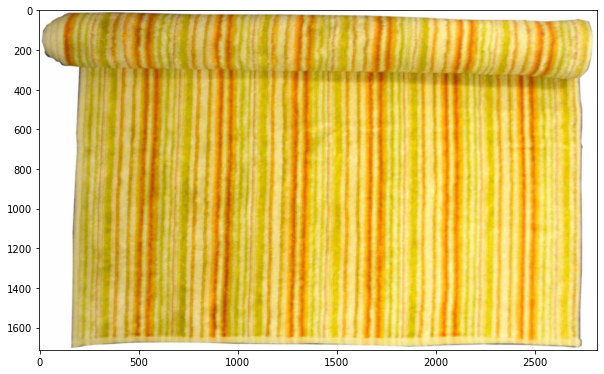

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(blur)
plt.show()

In [ ]:
def preprocessing(image):
    #Filtrage Gaussien
    im = cv2.GaussianBlur(image,(5,5),0)
     # Filtrage Median.
    #im= cv2.medianBlur(im, 3)
    #Equalize
    im = cv2.equalizeHist(im)
    return im

In [ ]:
train_preprocessed=[]
for i in range(len(train_loaded)):
    train_preprocessed.append(preprocessing(train_loaded[i]))

Extraction des descripteurs par ORB

In [ ]:
#application de l'algorithme orb
def orb_features(image):
  orb = cv2.ORB_create(nfeatures=500) # (50 descripteurs)
  key_points, description =  orb.detectAndCompute(image, None) # ORB descriptors : 128-dimensional vectors
  return key_points, description, image


def show_orb_features(image, color_img, kp):
  return plt.imshow(cv2.drawKeypoints(image,key_points,image, ))

Number of Keypoints: 384


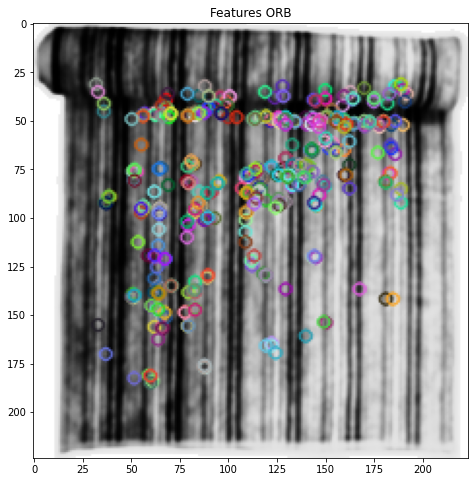

In [ ]:
orb = cv2.ORB_create()
#find keypoints and descriptors
key_points, description = orb.detectAndCompute(train_preprocessed[1], None)
#draw only keypoints location, not size and orientation:
image_orb = cv2.drawKeypoints(train_preprocessed[1],key_points,train_preprocessed[1], )
print('Number of Keypoints:',len(key_points))
plt.figure(figsize=(10,8))
plt.title('Features ORB')
plt.imshow(image_orb)
plt.show()


La localisation des descripteurs de l'image ci-dessus est représenté par les ronds de couleur

Extraction des features de chaque image du train

In [ ]:
#liste_keypoints = []
liste_descripteurs = []
liste_image = []
for each_image in train_preprocessed:  #Pour chaque image du jeu de données
  kp, desc , image = orb_features(each_image) # Keypoints et descripteurs de l'image
  #liste_keypoints.append(kp)
  liste_descripteurs.append(desc) # I obtained the feature vector for each image (using ORB descriptors).
  liste_image.append(image)

In [ ]:
print('Dimension descripteurs élément 0 : ', liste_descripteurs[0].shape)
print('Dimension descripteurs élément 1 : ', liste_descripteurs[1].shape)

Dimension descripteurs élément 0 :  (136, 32)
Dimension descripteurs élément 1 :  (402, 32)


 concaténer les  descripteurs pour toutes les images  en ligne

In [ ]:
des_array = liste_descripteurs[0]
for i in range(1,len(liste_descripteurs)):
    des_array=np.concatenate((des_array,liste_descripteurs[i]))

In [ ]:
des_array.shape

(273025, 32)

In [ ]:
des_array= des_array.astype(float)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_scaled = sc.fit_transform(des_array)

In [ ]:
%%time
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=70)
cls.fit(data_scaled)
visual_words = cls.cluster_centers_

CPU times: user 9min 29s, sys: 5min 18s, total: 14min 48s
Wall time: 8min 48s


Construction des Bags Of Visual Words

In [ ]:
def bovw(train_descriptors):
  bovw= pd.DataFrame(columns=list(range(cls.cluster_centers_.shape[0])),index=list(range(len(train_descriptors))))


  for i in range(len(train_descriptors)):
    data_sc=sc.transform(train_descriptors[i]) # STANDARISE
    data_predict=pd.Series(cls.predict(data_sc)) # KMEANS.predict
    data= data_predict.value_counts().sort_index(ascending=True)

    for j in range(len(data)):
      bovw.iloc[i,data.index[j]]=data.values.tolist()[j]

  bovw.fillna(value=0,inplace=True)
  return bovw

In [ ]:
%%time
train_bovw= bovw(liste_descripteurs)

feautres images :

In [ ]:
train_bovw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,1,2,2,3,0,0,1,4,1,1,1,4,3,1,1,2,0,1,0,0,5,1,2,0,5,0,1,0,3,3,0,2,2,0,1,0,0,1,2,0,8,3,0,1,1,0,0,1,3,1,2,3,0,0,1,0,1,0,0,0,0,4,1,2,1,2,1,0,0,1
1,6,2,5,7,5,6,6,3,5,11,8,4,2,8,3,0,3,3,10,4,17,0,8,8,5,12,4,3,8,7,18,1,0,1,6,2,5,0,4,3,15,1,2,9,6,6,6,9,8,7,10,2,4,6,3,5,12,1,0,1,6,6,2,1,6,3,4,9,19,2
2,3,7,10,7,8,3,6,9,8,6,4,5,4,4,6,6,7,2,3,1,3,8,9,3,16,6,2,7,13,7,8,4,1,3,5,3,6,6,4,3,1,8,3,6,6,15,3,11,6,6,3,7,7,4,10,4,5,0,0,7,1,6,3,12,5,6,3,9,4,3
3,1,0,0,0,0,0,0,3,0,0,0,2,1,0,0,25,0,35,1,0,0,0,0,0,0,0,0,0,0,0,0,3,104,1,0,0,0,3,0,0,0,0,20,0,0,1,0,0,0,0,0,1,1,0,0,1,0,13,31,0,0,2,0,0,0,0,0,0,0,2
4,10,2,3,11,7,4,2,7,10,4,9,7,4,3,2,16,4,5,4,3,1,3,7,4,3,2,11,21,5,0,2,1,1,7,2,9,1,4,1,7,6,11,1,9,15,5,2,8,0,15,14,6,2,3,3,4,15,3,1,5,9,9,18,19,2,12,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3,5,3,4,3,8,8,7,4,3,4,6,1,7,7,2,1,0,7,5,1,13,7,11,5,7,11,5,1,10,19,7,2,4,2,8,7,0,4,8,3,18,5,7,7,7,9,2,3,2,3,9,5,6,11,16,3,0,0,1,8,16,6,9,4,8,7,14,7,1
836,0,1,0,0,0,1,0,2,0,0,0,2,1,0,0,8,0,67,0,3,9,4,0,0,0,0,0,1,2,0,0,0,4,0,6,0,0,0,0,0,0,1,1,4,0,0,0,1,7,0,0,1,0,0,1,0,0,18,0,0,0,0,1,1,4,1,0,3,0,2
837,0,0,0,0,0,4,14,2,0,5,0,1,3,1,0,2,0,13,5,0,10,3,0,4,0,3,0,2,0,0,4,0,0,1,2,2,2,0,1,4,4,7,2,2,3,1,0,0,6,2,1,2,1,1,0,0,1,34,2,3,1,2,0,0,2,1,4,3,0,1
838,6,9,2,10,2,6,10,7,14,6,1,18,0,8,2,14,1,3,4,6,0,6,9,7,9,1,6,6,16,5,13,1,3,2,5,4,1,1,5,9,1,7,2,13,4,3,4,8,3,9,9,13,15,5,8,5,6,1,3,4,2,11,18,6,13,6,3,3,8,10


Extraction des features sur les données visuelles **Test**

In [ ]:
%%time
test_loaded = load_images(test['image'])

CPU times: user 5.88 s, sys: 186 ms, total: 6.07 s
Wall time: 6.94 s


In [ ]:
test_preprocessed=[]
for i in range(len(test_loaded)):
    test_preprocessed.append(preprocessing(test_loaded[i]))

In [ ]:
liste_keypoints1 = []
liste_descripteurs1 = []
for each_image in test_preprocessed:  #Pour chaque image du jeu de données
  kp, desc,image = orb_features(each_image) # Keypoints et descripteurs de l'image
  liste_keypoints1.append(kp)
  liste_descripteurs1.append(desc)

In [ ]:
test_bovw= bovw(liste_descripteurs1)

In [ ]:
test_bovw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,6,3,1,1,1,1,4,4,1,3,0,0,1,3,1,1,0,1,3,5,1,1,0,2,2,0,2,8,3,0,0,0,2,0,4,1,2,1,2,2,5,2,15,1,0,11,2,3,0,0,1,1,0,0,0,6,13,0,0,1,0,0,4,1,2,5,0,5,1,1
1,3,4,4,3,2,9,2,0,3,15,4,12,8,12,4,2,11,4,4,0,1,5,1,4,4,2,9,2,2,4,4,12,4,2,6,4,3,5,2,0,1,1,20,6,8,2,2,0,5,2,1,8,6,5,5,4,2,0,7,3,5,0,19,8,7,4,7,8,5,3
2,1,0,0,1,1,2,6,1,0,1,0,10,0,0,1,1,2,2,1,0,1,0,1,0,0,0,0,0,1,2,2,2,3,1,1,0,4,3,0,7,4,0,7,0,0,2,0,0,2,0,1,0,0,8,0,3,1,0,3,0,1,0,1,1,0,0,0,1,1,0
3,5,9,11,13,13,6,4,3,2,9,8,12,6,5,1,7,6,9,4,4,13,10,2,4,3,8,9,4,5,7,2,15,7,4,7,7,7,6,6,3,1,4,0,6,6,9,3,1,5,12,4,2,8,1,10,6,2,10,4,4,9,0,10,1,6,3,11,6,3,6
4,16,1,2,2,6,10,9,1,0,6,9,12,3,9,1,1,12,14,6,1,11,12,0,3,1,2,4,0,3,1,7,15,27,0,8,0,1,10,5,0,6,0,0,5,2,8,0,2,2,4,24,5,22,5,4,20,3,1,10,8,11,0,8,13,2,4,9,5,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,7,3,4,6,14,9,6,3,4,5,17,7,14,14,2,8,6,7,5,0,5,4,0,7,8,5,9,2,7,2,11,5,12,2,4,9,7,8,7,1,0,8,0,3,2,8,2,5,2,2,3,8,8,5,9,7,6,6,7,6,10,3,6,14,9,5,3,7,10,1
206,0,6,4,3,1,2,3,2,4,3,1,9,3,1,3,8,7,5,6,3,5,4,8,4,8,11,5,2,7,9,3,0,2,13,2,5,2,16,2,2,17,8,2,2,15,11,5,5,4,7,5,3,2,7,7,3,11,3,8,4,1,2,6,6,6,9,6,8,3,2
207,4,0,3,0,0,0,1,1,0,0,1,0,2,1,1,1,0,0,0,4,0,0,6,1,0,0,2,0,0,4,2,0,0,0,4,2,3,2,3,1,1,4,2,0,0,1,9,0,2,2,0,0,2,1,1,2,4,0,0,2,0,0,6,3,2,2,0,2,1,1
208,0,5,2,2,3,4,6,3,5,4,3,0,9,11,4,3,2,2,9,1,1,6,1,4,6,0,10,4,2,10,3,1,2,4,6,8,9,10,4,2,6,2,2,9,3,2,5,9,7,4,0,13,8,6,5,1,7,3,8,2,1,0,5,7,4,1,7,8,6,0


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"learning_rate":[5,1,0.1,0.01,0.001],
'n_estimators':[20,30,50,100,200]}

xgb_grid = GridSearchCV(XGBClassifier(),
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

xgb_grid.fit(train_bovw, train.product_category_1)

CPU times: user 1min 26s, sys: 384 ms, total: 1min 27s
Wall time: 1min 27s


In [ ]:
xgb_grid.best_score_

0.3178571428571429

In [ ]:
xgb_grid.best_params_

{'learning_rate': 1, 'n_estimators': 30}

In [ ]:
 print('accuracy sur jeu test : ',accuracy_score(test.product_category_1,xgb_grid.best_estimator_.predict(test_bovw)))

accuracy sur jeu test :  0.2571428571428571


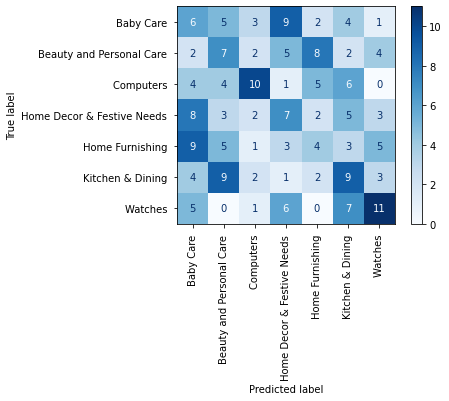

In [ ]:
plot_confusion_matrix(xgb_grid.best_estimator_,
                      test_bovw,
                      test['product_category_1'],
                      xticks_rotation=90,
                      cmap='Blues')

plt.show()

In [ ]:
%%time
silhouettes= []
result_clusters=[]
df_coef_silhouettes=pd.DataFrame()
k_range= range(2,20)
#1ere loop pour observe la stabilite
for num_cls in k_range:
    model = KMeans(n_clusters =num_cls,init='k-means++').fit(train_bovw)
    #On enregistre les scores de coefficient de silhouette à chaque passage
    silhouettes.append(silhouette_score(train_bovw,model.labels_))
    result_clusters.append(num_cls)

df_coef_silhouettes['silhouettes']=silhouettes
df_coef_silhouettes["nbr_clusters"] = result_clusters
silhouettes=[]
result_clusters=[]

CPU times: user 5.5 s, sys: 4.51 s, total: 10 s
Wall time: 5.09 s


In [ ]:
 best_iter =df_coef_silhouettes.where(df_coef_silhouettes["silhouettes"] ==df_coef_silhouettes["silhouettes"].max())
 best_iter.dropna(how="any", inplace=True)
 best_iter

,silhouettes,nbr_clusters
0,0.175851,2.0


Text(0.5, 1.0, 'Variation du coefficient de silhouette')

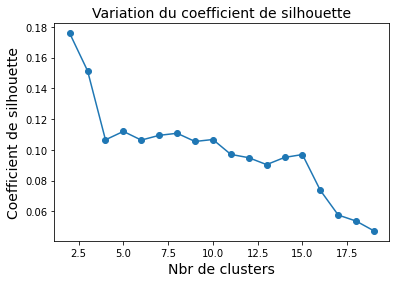

In [ ]:
plt.plot(df_coef_silhouettes["nbr_clusters"],df_coef_silhouettes["silhouettes"], marker="o")
plt.xlabel("Nbr de clusters", size=14)
plt.ylabel("Coefficient de silhouette", size=14)
plt.title("Variation du coefficient de silhouette", size=14)

In [ ]:
km = KMeans(n_clusters=7)
km.fit(train_bovw)
pred = km.labels_
df_kmeans = pd.DataFrame()
df_kmeans["labels"] = km.labels_
df_kmeans["nbr_individus"] = 0
df_kmeans = df_kmeans.groupby("labels", as_index=False).count()
silh = round(silhouette_score(train_bovw, km.labels_), 2)
ari = round(adjusted_rand_score(train['product_category_1'], km.labels_), 2)
print("Coef silhouette :", silh)
print("Score Adjusted Rand index :", ari)

results = pd.Series(km.labels_,index=train['image'])
results

Coef silhouette : 0.1
Score Adjusted Rand index : 0.04


image
63f6ef8f3fda2c306b27cfbf5a005f1e.jpg    6
463492671c5c19316a0fb9fe1c53da48.jpg    1
b6c339777814451815fe7950fd4c8536.jpg    0
1dbe1f3ba28460dffef4a1d664549621.jpg    3
cc24426f00c1cf9ae0bf76e8bd23c336.jpg    0
                                       ..
a79117ea49a0533f641facdb4c99f502.jpg    1
394c2c627914e1eed9b8ac343583a679.jpg    4
fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg    6
0906fd9cc604fbba05a502e01d763cd9.jpg    2
719677b02bfccafb86e9be78f36f938b.jpg    2
Length: 840, dtype: int32

In [ ]:
df_kmeans

,labels,nbr_individus
0,0,227
1,1,186
2,2,176
3,3,30
4,4,20
5,5,38
6,6,163


In [ ]:
results

image
63f6ef8f3fda2c306b27cfbf5a005f1e.jpg    6
463492671c5c19316a0fb9fe1c53da48.jpg    1
b6c339777814451815fe7950fd4c8536.jpg    0
1dbe1f3ba28460dffef4a1d664549621.jpg    3
cc24426f00c1cf9ae0bf76e8bd23c336.jpg    0
                                       ..
a79117ea49a0533f641facdb4c99f502.jpg    1
394c2c627914e1eed9b8ac343583a679.jpg    4
fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg    6
0906fd9cc604fbba05a502e01d763cd9.jpg    2
719677b02bfccafb86e9be78f36f938b.jpg    2
Length: 840, dtype: int32

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


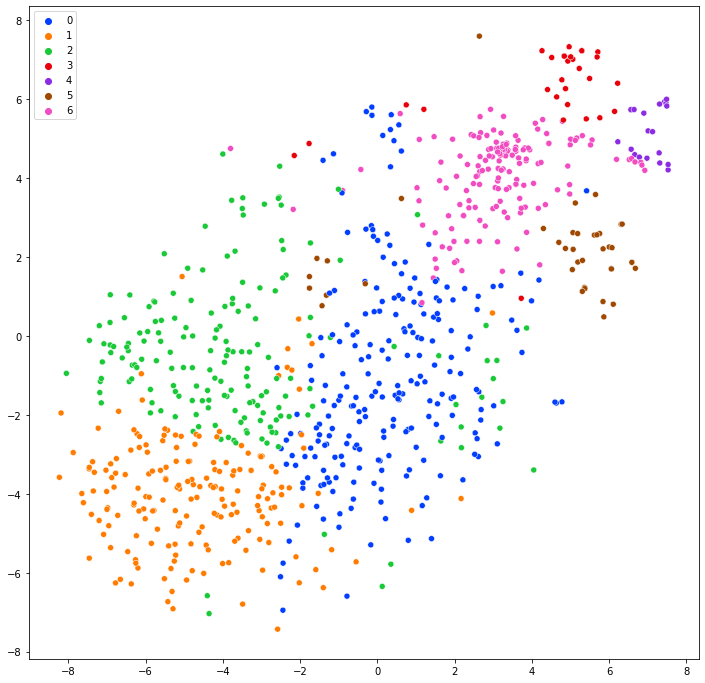

In [ ]:
tsne = TSNE(n_jobs=-1, perplexity=120)
X_tsne = tsne.fit_transform(train_bovw)
fig = plt.figure(figsize=(12, 12))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1],
                hue=km.labels_, legend='full', palette=pal)

**CNN Convolutionnal Neural Network**

Dans cette partie, on a utilise le transfer learning. Il s'agit d'utiliser un réseau de neurones déjà entraîné sur image net

Modèle Resnet50 qui est une version du réseau de neurones convolutif

 **Extraction de feature avec Resnet50**

In [ ]:
model = ResNet50(weights='imagenet', include_top=False)# include_top : remove the last layer
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
img = image.load_img(path1, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)
resnet50_feature = model.predict(img_data)
print(resnet50_feature.shape)

(1, 7, 7, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


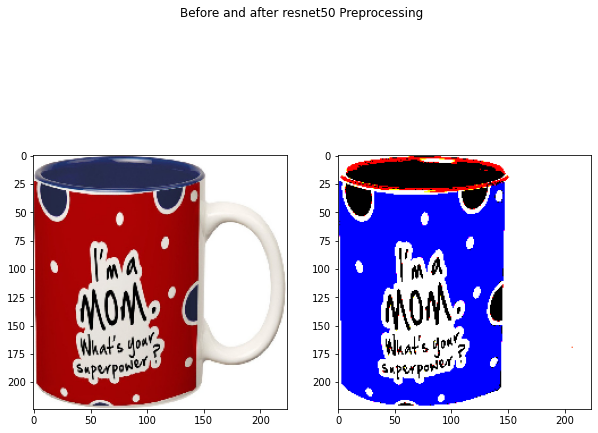

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
fig.suptitle('Before and after resnet50 Preprocessing ')
ax1.imshow(img)
ax2.imshow(img_data[0])

In [ ]:
%%time
resnet50_feature_list = []
for each_image in train['image']:

    full_path= os.path.join(path,each_image)
    img = image.load_img(full_path, target_size=(224, 224)) # Charger l'image
    img_data = image.img_to_array(img)  # Convertir en tableau numpy  img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data) #Prétraiter l'image comme le resnet50
    # get extracted features
    resnet50_feature = model.predict(img_data)
    resnet50_feature_np = np.array(resnet50_feature)
    resnet50_feature_list.append(resnet50_feature_np.flatten())


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


CPU times: user 5min 41s, sys: 25.1 s, total: 6min 6s
Wall time: 3min 56s


In [ ]:
print("Dimension vecteur par image :", len(resnet50_feature_list[0]))
print("Nombre total de vecteurs :", len(resnet50_feature_list))

Dimension vecteur par image : 100352
Nombre total de vecteurs : 840


In [ ]:
df_resnet = pd.DataFrame.from_records(resnet50_feature_list)
df_resnet.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100312,100313,100314,100315,100316,100317,100318,100319,100320,100321,100322,100323,100324,100325,100326,100327,100328,100329,100330,100331,100332,100333,100334,100335,100336,100337,100338,100339,100340,100341,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351
0,0.0,0.0,0.0,0.0,0.0,0.0,3.315237,2.313689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,4.572585,0.0,0.0,2.030550,0.000000,0.000000,0.0,0.0,1.111012,...,0.0,2.966866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.897169,0.0,0.924406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.313648,0.0,0.0,0.0,13.505401,0.0,0.0,0.0,0.0,1.101812,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,6.291767,3.496816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.970045,0.0,1.375848,0.0,0.000000,0.0,0.0,2.534562,0.000000,1.343757,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.868348,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,4.080635,2.318574,0.000000,0.0,0.0,0.000000,...,0.0,0.220318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.991917,3.397599,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,2.224312,0.0,0.0,0.0,0.0,5.657844,0.0,10.600929,0.000000,0.0,5.137149
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.236381,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,5.810410,0.520134,0.000000,0.0,0.0,0.000000,...,0.0,1.271676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.330194,0.0,0.0,3.471375,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,10.729597,0.0,0.0,0.0,0.0,0.168603,0.0,0.000000,2.165301,0.0,0.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


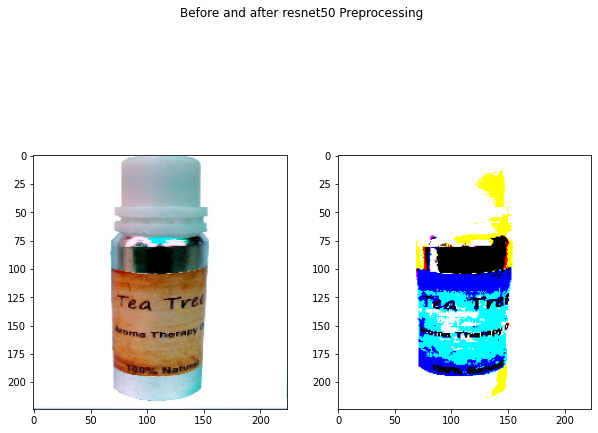

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
fig.suptitle('Before and after resnet50 Preprocessing ')
ax1.imshow(img)
ax2.imshow(img_data[0])

In [ ]:
train["resnet50"] =  ""
for i in range(train.shape[0]):
    train["resnet50"][i] = resnet50_feature_list[i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
train

,newdescription,image,product_category_1,tf_idf,resnet50
504,buy lapguard hp pavilion dvax cell laptop batt...,cd089e2ef349a7f00dcdbf28965914f6.jpg,Computers,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
175,buy prithish im mom whats superpower red blue ...,22ea3b69860bc9a5e0c69b87db2dcdab.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.08277642, 0.066347...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61,specification rythmx fb nail polish black lips...,95330f6f0f44d17b918feec36bedcdef.jpg,Beauty and Personal Care,"[0.0, 0.09762913, 0.0, 0.101963185, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
777,rrtc rrtcsm basic analog watch woman buy rrtc ...,46c7cb82a768ad8811db821d8649f6e0.jpg,Watches,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
158,buy prithish friend indeed ceramic mug r onlin...,41fd5af61752be98b19b611a6ff9a0ef.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4312165,..."
...,...,...,...,...,...
231,lal haveli beautifully crafted painted horse b...,f8c1b5fb422d8418dc9e40a43fece55a.jpg,Home Decor & Festive Needs,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
970,key feature bela home cotton cartoon single be...,3e2b2a04696f7d83a7835e9894d79df7.jpg,Baby Care,,
996,key feature l oreal eversleek sulfate free smo...,873a955df5a2f677a41a7efc94060e41.jpg,Baby Care,,
430,key feature ocean vglass pack ocean vglass ml ...,a54b94096938252901d3f7f8de97bffb.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
nmf_resnet50 = NMF(n_components=train.product_category_1.nunique(),random_state=1,alpha=0.1,l1_ratio=0.5,init='nndsvd')
nmf_df_resnet50= nmf_resnet50.fit_transform(df_res50)

In [ ]:
km1 = KMeans(n_clusters=7)
km1.fit(df_resnet)
km_label = km1.labels_

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
label=train['product_category_1']
ari_km = adjusted_rand_score(label, km_label)

In [ ]:
print("Score Adjusted Rand index :", ari_km)

Score Adjusted Rand index : 0.3262405727759149


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


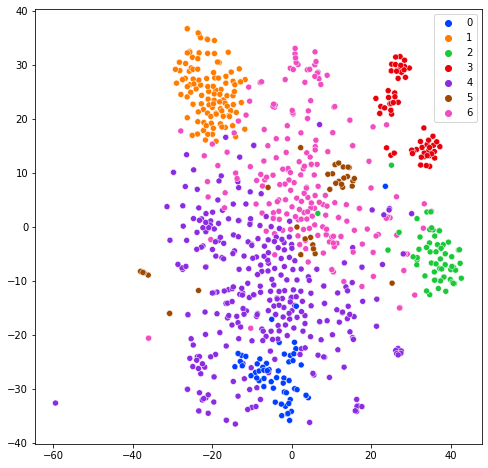

In [ ]:
tsne_resnet = TSNE()
X_tsne_resnet = tsne_resnet.fit_transform(df_resnet)
fig = plt.figure(figsize=(8, 8))
pal = sns.color_palette("bright", 7)
sns.scatterplot(X_tsne_resnet[:, 0], X_tsne_resnet[:, 1],hue=km_label , legend='full', palette=pal)

Un autre CNN, le modèle VGG16.

 VGG16 Features Extraction

In [ ]:
# Création d'un réseau de neurones vide
model = Sequential()
vgg= VGG16(weights="imagenet",include_top=True) # input_shape=(224, 224, 3)

553467904/553467096 [==============================] - 7s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
for i in range(len(vgg.layers)-1) :
    vgg.layers[i].trainable = False
    model.add(vgg.layers[i])
# Ajout de la couche Dense de prédiciton adaptée à notre problème de classifications (7 classes).
#model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Fonction d'extraction des feature pour le train

In [ ]:
%%time
vgg_feature_list = []
for each_image in train['image']:

    full_path= os.path.join(path,each_image)
    img = image.load_img(full_path, target_size=(224, 224)) # Charger l'image
    img_data = image.img_to_array(img)  # Convertir en tableau numpy  img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    # get extracted features
    vgg_feature = model.predict(img_data)
    vgg_feature_np = np.array(vgg_feature)
    vgg_feature_list.append(vgg_feature_np.flatten())

CPU times: user 15min 39s, sys: 4.18 s, total: 15min 43s
Wall time: 8min 56s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


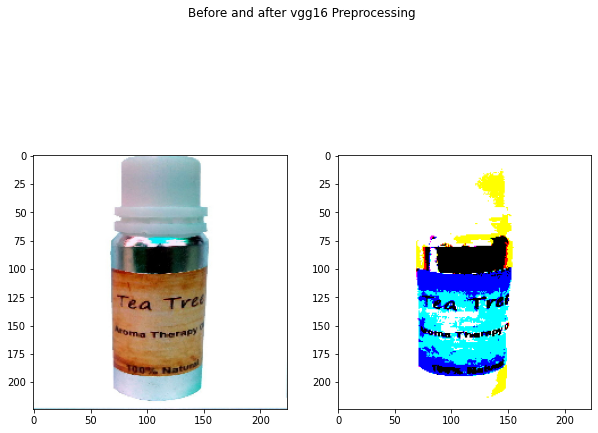

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
fig.suptitle('Before and after vgg16 Preprocessing ')
ax1.imshow(img)
ax2.imshow(img_data[0])

In [ ]:
train_features_vgg = pd.DataFrame.from_records(vgg_feature_list)

In [ ]:
train_features_vgg.shape

(840, 4096)

In [ ]:
train["vgg16"] =  ""
for i in range(train.shape[0]):
    train["vgg16"][i] = vgg_feature_list[i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
train.head()

,newdescription,image,product_category_1,tf_idf,resnet50,vgg16
504,buy lapguard hp pavilion dvax cell laptop batt...,cd089e2ef349a7f00dcdbf28965914f6.jpg,Computers,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9765922, 0.0, 0.0, 0.0, 0.0, 1.1703782, 2.7..."
175,buy prithish im mom whats superpower red blue ...,22ea3b69860bc9a5e0c69b87db2dcdab.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.08277642, 0.066347...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.4849676, 0.0, 0.0, 5.56253, ..."
61,specification rythmx fb nail polish black lips...,95330f6f0f44d17b918feec36bedcdef.jpg,Beauty and Personal Care,"[0.0, 0.09762913, 0.0, 0.101963185, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
777,rrtc rrtcsm basic analog watch woman buy rrtc ...,46c7cb82a768ad8811db821d8649f6e0.jpg,Watches,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.4782825, 0.0, 0.0, 2.8935814, 0.0, 3.6..."
158,buy prithish friend indeed ceramic mug r onlin...,41fd5af61752be98b19b611a6ff9a0ef.jpg,Kitchen & Dining,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4312165,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Fonction d'extraction des feature pour le test

In [ ]:
%%time
vgg_feature_list_test = []
for each_image in test['image']:

    full_path= os.path.join(path,each_image)
    img = image.load_img(full_path, target_size=(224, 224)) # Charger l'image
    img_data = image.img_to_array(img)  # Convertir en tableau numpy  img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    # get extracted features
    vgg_feature = model.predict(img_data)# compile, fit
    vgg_feature_np = np.array(vgg_feature)
    vgg_feature_list_test.append(vgg_feature_np.flatten())

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


CPU times: user 3min 55s, sys: 1.87 s, total: 3min 57s
Wall time: 2min 15s


In [ ]:
test_features_vgg = pd.DataFrame.from_records(vgg_feature_list_test)

In [ ]:
test_features_vgg.shape

(210, 4096)

classification vgg16

In [ ]:
x = model.output
output= Dense(7, activation='softmax')(x)
# Ajout de la couche Dense de prédiciton adaptée à notre problème de classifications (7 classes).
new_model=Model(inputs=model.inputs, outputs=output)
#model.add(Dense(7, activation='softmax'))

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def load_keras(list_of_path):

    for i in range(len(list_of_path)):
        if i ==0:
            fullpath =os.path.join(path,train.iloc[i,1])
            img = image.load_img(fullpath, target_size=(224, 224))
            img = image.img_to_array(img)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
        else:
            fullpath =os.path.join(path,train.iloc[i,1])
            im = image.load_img(fullpath, target_size=(224, 224))
            im = image.img_to_array(im)
            im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            im = preprocess_input(im)
            img = np.concatenate((img, im), axis=0)

    return img

In [ ]:
%%time
x_train=load_keras(train.image)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


CPU times: user 1min 29s, sys: 3.46 s, total: 1min 33s
Wall time: 1min 35s


In [ ]:
x_train.shape

(840, 224, 224, 3)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
y_train = ohe.fit_transform(np.array(train.product_category_1).reshape(-1,1)).todense()

In [ ]:
%%time
# Compiler le  modèle
new_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
# Compiler le modèle

# Entraîner sur les données d'entraînement (x_train, y_train)
model_info = new_model.fit(x_train, y_train, epochs=5, batch_size=50, verbose=2)

Epoch 1/5
17/17 - 429s - loss: 1.1753 - accuracy: 0.6655
Epoch 2/5
17/17 - 431s - loss: 0.3877 - accuracy: 0.8881
Epoch 3/5
17/17 - 422s - loss: 0.1796 - accuracy: 0.9405
Epoch 4/5
17/17 - 429s - loss: 0.0969 - accuracy: 0.9762
Epoch 5/5
17/17 - 428s - loss: 0.0486 - accuracy: 0.9929
CPU times: user 1h 9min 4s, sys: 25 s, total: 1h 9min 29s
Wall time: 35min 39s


In [ ]:
x_test.shape

(210, 224, 224, 3)

In [ ]:
test_pred.shape

(210, 7)

In [ ]:
%%time
# Predict categories so as to have a first preview of model accuracy
train_pred = new_model.predict(x_train)
x_test = load_keras(test.image)
y_test = ohe.transform(np.array(test.product_category_1).reshape(-1,1)).todense()
test_pred = new_model.predict(x_test)

CPU times: user 17min 24s, sys: 3.84 s, total: 17min 28s
Wall time: 9min 2s


In [ ]:
# Compare predicted category with actual category

print('Train Score (accuracy): ',accuracy_score(np.argmax(train_pred, axis=1).reshape(-1,1),
                                                np.argmax(y_train, axis=1).reshape(-1,1)))

Train Score (accuracy):  0.9964285714285714


In [ ]:
print('Test Score (accuracy): ',accuracy_score(np.argmax(test_pred, axis=1).reshape(-1,1),np.argmax(y_test, axis=1).reshape(-1,1)))

Test Score (accuracy):  0.16666666666666666


**Classification**

Pour résumé, on a effectuée :

- Extraction des features des données textes par la méthode TF-IDF et BOW
- Extraction des features des images avec un algorithme d'extraction (ORB)
- Extraction des features des images avec un CNN (VGG-16) et (Resnet50)

maintenant on va effectuer une classification multi-classes. afin d'évaluer la plus performante :

- Features textes avec TF-IDF & features images avec Resnet50
- Features textes avec TF-IDF & features images avec VGG16

**Regroupement des features issue de TF-IDF et resnet50**

On concatène les dataframes pour le classification.

In [ ]:
df_concat= pd.concat([tfidf_train,df_resnet], axis=1)

In [ ]:
df_concat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100312,100313,100314,100315,100316,100317,100318,100319,100320,100321,100322,100323,100324,100325,100326,100327,100328,100329,100330,100331,100332,100333,100334,100335,100336,100337,100338,100339,100340,100341,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.378905,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,2.966866,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.897169,0.0,0.924406,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.313648,0.000000,0.0,0.000000,13.505401,0.0,0.0,0.000000,0.0,1.101812,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.125055,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.868348,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.137656,0.0,...,0.0,0.220318,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.991917,3.397599,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.224312,0.0,0.0,0.000000,0.0,5.657844,0.0,10.600929,0.000000,0.000000,5.137149
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.482119,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.141635,0.000000,0.0,...,0.0,1.271676,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.330194,0.000000,0.0,3.471375,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,10.729597,0.0,0.0,0.000000,0.0,0.168603,0.0,0.000000,2.165301,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.389674,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.163320,0.451336,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.901066,0.0,0.0,0.0,0.0,0.0,0.000000,11.369515,0.000000,0.000000,0.0,3.513380,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,4.550674,0.000000,0.0,0.000000,11.660686,0.0,0.0,0.035042,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.111477
836,0.0,0.0,0.0,0.049169,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.063036,0.0,0.0,0.0,0.000000,0.040587,0.000000,0.0,0.090743,0.0,0.393352,0.023963,0.000000,0.0,...,0

In [ ]:
%%time
silhouettes= []
result_clusters=[]
df_coef_silhouettes=pd.DataFrame()
k_range= range(2,20)
for num_cls in k_range:
    model = KMeans(n_clusters =num_cls,init='k-means++').fit(df_concat)
    silhouettes.append(silhouette_score(df_concat,model.labels_))
    result_clusters.append(num_cls)

df_coef_silhouettes['silhouettes']=silhouettes
df_coef_silhouettes["nbr_clusters"] = result_clusters
silhouettes=[]
result_clusters=[]

CPU times: user 44min 47s, sys: 4min 43s, total: 49min 30s
Wall time: 38min 30s


In [ ]:
 best_iter =df_coef_silhouettes.where(df_coef_silhouettes["silhouettes"] ==df_coef_silhouettes["silhouettes"].max())
 best_iter.dropna(how="any", inplace=True)
 best_iter

,silhouettes,nbr_clusters
15,0.039079,17.0


Text(0.5, 1.0, 'Variation du coefficient de silhouette')

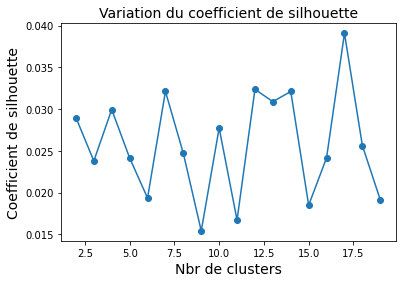

In [ ]:
plt.plot(df_coef_silhouettes["nbr_clusters"],df_coef_silhouettes["silhouettes"], marker="o")
plt.xlabel("Nbr de clusters", size=14)
plt.ylabel("Coefficient de silhouette", size=14)
plt.title("Variation du coefficient de silhouette", size=14)

In [ ]:
%%time
km_concat = KMeans(n_clusters=7)
km_concat.fit(df_concat)
df_kmeans = pd.DataFrame()
df_kmeans["labels"] = km_concat.labels_
df_kmeans["nbr_individus"] = 0
df_kmeans = df_kmeans.groupby("labels", as_index=False).count()

CPU times: user 2min 11s, sys: 5.62 s, total: 2min 17s
Wall time: 2min 2s


In [ ]:
silh = round(silhouette_score(df_concat, km_concat.labels_), 2)
ari = round(adjusted_rand_score(train['product_category_1'], km_concat.labels_), 2)
print("Coef silhouette :", silh)
print("Score Adjusted Rand index :", ari)

Coef silhouette : 0.02
Score Adjusted Rand index : 0.3


In [ ]:
tsne = TSNE()
data_TSNE = tsne.fit_transform(df_concat)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


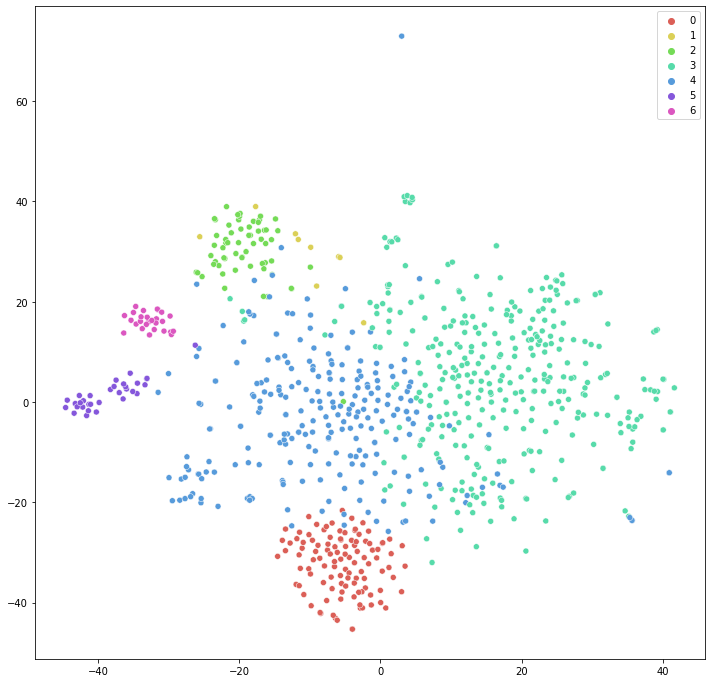

In [ ]:
fig = plt.figure(figsize=[12,12])
sns.scatterplot(data_TSNE[:,0],data_TSNE[:,1],hue=km_concat.labels_,legend='full',palette=sns.color_palette("hls",7))
plt.legend()

**Regroupement des features issue de TF-IDF et vgg16**

Concaténation des dataframes avec réalisation d'une ACP afin de faire une réduction dimensionnelle

**Réduction PCA**

In [ ]:
train_features_vgg.shape

(840, 4096)

In [ ]:
tfidf_train.shape

(840, 400)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=400)
train_pca_vgg = pd.DataFrame(pca.fit_transform(train_features_vgg))

In [ ]:
test_pca_vgg= pd.DataFrame(pca.transform(test_features_vgg))

In [ ]:
test_features_vgg.shape

(210, 4096)

Text(0.5, 1.0, 'Courbe de variance cumulée')

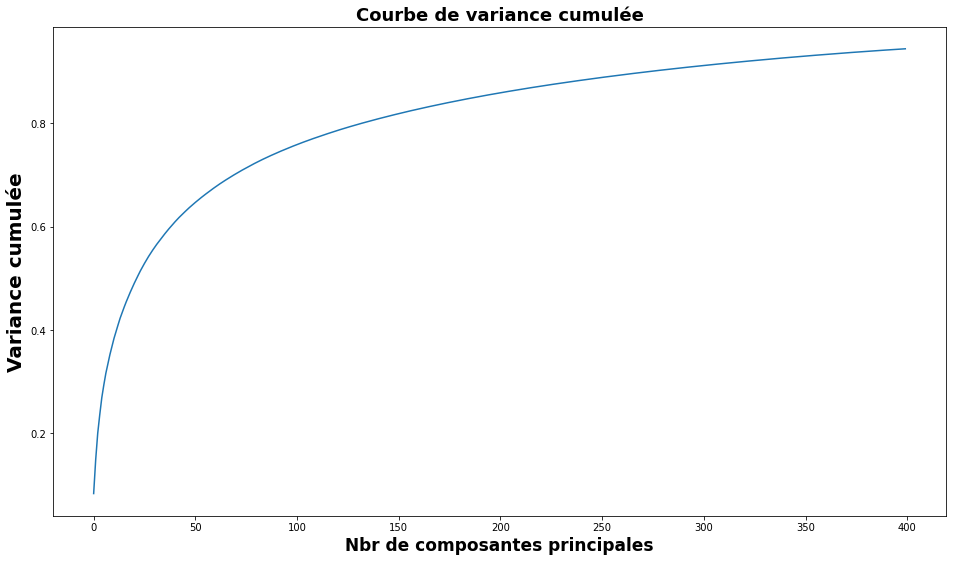

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Courbe de variance cumulée', size=18, weight='bold')

Il faut 350 composantes pour expliquer 95% de la variance du dataset

In [ ]:
# Combien doit-on garder de composantes principales pour expliquer 95% de la variance du dataset ?

In [ ]:
train_concat_2= pd.concat([tfidf_train, train_pca_vgg], axis=1)

In [ ]:
test_concat_2= pd.concat([tfidf_test,test_pca_vgg],axis=1)

In [ ]:
paramts ={'learning_rate': [1,0.1,0.01,0.001],
          'n_estimators':[10,50,100,200]}
xgb3 = GridSearchCV(GradientBoostingClassifier(), param_grid = paramts, cv=5,verbose=0)
xgb3.fit(train_concat_2,train['product_category_1'])

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [ ]:
xgb3.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [ ]:
print('accuracy sur jeu test : ', accuracy_score(xgb3.best_estimator_.predict(test_concat_2), test['product_category_1']))

accuracy sur jeu test :  0.9142857142857143


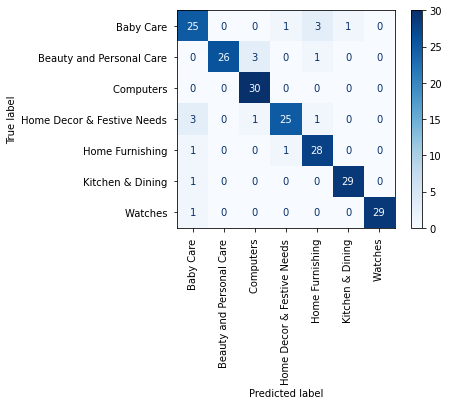

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb3,test_concat_2,
                      test['product_category_1'],
                      xticks_rotation=90,
                      cmap='Blues')

plt.show()